<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
from fastai.vision.all import *

In [ ]:
### Get files and annos ###
path = Path('/home/rory/data/coco2017')

def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys

train_files, train_annos = get_annos(path,'annotations/instances_train2017.json', 'train2017')
valid_files, valid_annos = get_annos(path,'annotations/instances_val2017.json',   'val2017')
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]

In [ ]:
### Process annos ###
def transpose(anno): return list(zip(*anno))
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)

sorted_annos = L(sort_annos(i) for i in annos)
largest_anno = L(i[0] for i in sorted_annos)
largest_bbox = L(i[0] for i in largest_anno)
largest_lbl  = L(i[1] for i in largest_anno)

In [ ]:
### Create dataset ###
def x2y(x,y): return {a:b for a,b in zip(x,y)}
files2lbls = x2y(files, largest_lbl)
def get_lbl(x): return files2lbls[x]
# files2bboxs = x2y(files, largest_bbox) # getting ahead of myself
# def get_bbox(x): return files2bboxs[x]

splits = (L(range(len(train_files))),
          L(range(len(valid_files))).map(lambda x: x + len(train_files)))

dss_tfms = [[PILImage.create],[get_lbl, Categorize]]
dss = Datasets(files, tfms=dss_tfms, splits=splits)

In [ ]:
dss.train[0]

(PILImage mode=RGB size=640x360, TensorCategory(49))

In [ ]:
cpu_tfms = [Resize(224, method=ResizeMethod.Squish), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize()]
dls = dss.dataloaders(bs=64, after_item=cpu_tfms, after_batch=gpu_tfms)

In [ ]:
x,y = dls.one_batch(); x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [ ]:
### Model ###
def convlayr(i, o): return ConvLayer(i, o, stride=2)
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf, nf, stride=1)
        self.conv2 = ConvLayer(nf, nf, stride=1)
    def forward(self, x): return x + self.conv2(self.conv1(x))
def conv_res(i,o): return nn.Sequential(convlayr(i,o), ResBlock(o))

p = 20
mod = nn.Sequential(
    conv_res(3  ,p*1),
    conv_res(p*1,p*2),
    conv_res(p*2,p*4),
    conv_res(p*4,p*2),
    convlayr(p*2,dls.c),
    Flatten())


### Train ###
learn = Learner(dls, mod, metrics=accuracy)

In [ ]:
learn.summary()
# 3 x 224 x 224  = 150,528
# 20 x 112 x 112 = 250,880

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 20 x 112 x 112  540        True      
________________________________________________________________
BatchNorm2d          64 x 20 x 112 x 112  40         True      
________________________________________________________________
ReLU                 64 x 20 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 20 x 112 x 112  3,600      True      
________________________________________________________________
BatchNorm2d          64 x 20 x 112 x 112  40         True      
________________________________________________________________
ReLU                 64 x 20 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 20 x 112 x 112  3,600      True      
_________________________________________________

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0020892962347716093)

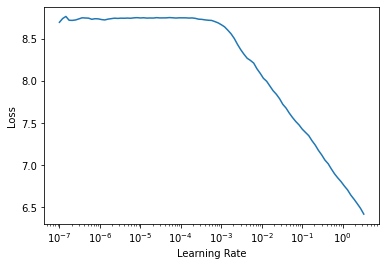

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=3e-1)

epoch,train_loss,valid_loss,accuracy,time
